Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

trainval_df:
       validation  tot_ct  ex_ct         y          x
0           False      28      2  0.023406  GGAGUGAUG
1           False     193     15 -0.074999  UUCGCGCCA
2           False      27      0 -0.438475  UAAGCUUUU
3           False     130      2 -0.631467  AUGGUCGGG
4           False     552     19 -0.433012  AGGGCAGGA
...           ...     ...    ...       ...        ...
24400       False     167   1467  1.950100  GAGGUAAAU
24401       False     682     17 -0.570465  AUCGCUAGA
24402       False     190     17 -0.017078  CUGGUUGCA
24403       False     154     10 -0.140256  CGCGCACAA
24404       False     265      6 -0.571100  AUAGUCUAA

[24405 rows x 5 columns]
AdditiveGPMapLayer
N = 30,483 observations set as training dat

 16%|███▋                   | 80/500 [01:37<08:33,  1.22s/epoch, loss=65.8, I_var=-.0405, val_loss=59.7, val_I_var=0.00211]


Training time: 98.4 seconds
K1
N = 30,483 observations set as training data.
Using 19.5% for validation.
Time to set data: 3.66 sec.


 42%|█████████▋             | 211/500 [03:44<05:06,  1.06s/epoch, loss=65.8, I_var=-.0565, val_loss=59.9, val_I_var=-.0157]


Training time: 224.8 seconds
PairwiseGPMapLayer
N = 30,483 observations set as training data.
Using 19.5% for validation.
Time to set data: 0.656 sec.


 29%|███████▎                 | 147/500 [01:36<03:52,  1.52epoch/s, loss=35.7, I_var=0.165, val_loss=34.9, val_I_var=0.168]


Training time: 97.2 seconds
K2
N = 30,483 observations set as training data.
Using 19.5% for validation.
Time to set data: 0.64 sec.


 26%|██████▊                   | 131/500 [00:51<02:26,  2.52epoch/s, loss=19.6, I_var=0.255, val_loss=22.3, val_I_var=0.24]


Training time: 52.2 seconds
K3
N = 30,483 observations set as training data.
Using 19.5% for validation.
Time to set data: 0.57 sec.


 12%|███                       | 60/500 [04:46<35:04,  4.78s/epoch, loss=-2.18, I_var=0.41, val_loss=16.1, val_I_var=0.282]


Training time: 315.2 seconds


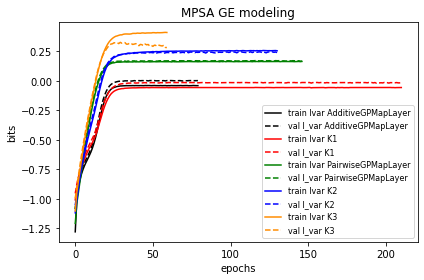

In [1]:
import os
import warnings
# Ignore tensorflow CUDA backend warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
# Path to local mavenn
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')
import mavenn

dataset = 'mpsa'
# Load example data
data_df = mavenn.load_example_dataset(dataset)

# Split dataset
trainval_df, test_df = mavenn.split_dataset(data_df)

# Preview trainval_df
print('trainval_df:')
print(trainval_df)

# Length of the sequences
L = len(data_df['x'][0])
# Alphabet for RNA
alphabet = ['A', 'C', 'G', 'U']

# Default fitting kwargs
default_fit_kwargs = {
    'learning_rate': 5e-4,
    'epochs': 500,
    'batch_size': 200,
    'early_stopping': True,
    'early_stopping_patience': 30,
    'linear_initialization': False,
    'verbose': False
}


gpmap_cases = ['AdditiveGPMapLayer',
               'K1',
               'PairwiseGPMapLayer',
               'K2',
               'K3']
line_colors = ['k', 'r', 'g', 'b', 'darkorange', 'purple']
fig, ax = plt.subplots(1, 1)

# Loop over gp-map implementations
for c, g in enumerate(gpmap_cases):
    print(g)
    if g == 'AdditiveGPMapLayer':
        gpmap = mavenn.gpmap.AdditiveGPMapLayer(L=L, alphabet=alphabet)

    if g == 'K1':
        gpmap = mavenn.gpmap.KOrderGPMap(
            L=L, alphabet=alphabet, interaction_order=1)

    if g == 'PairwiseGPMapLayer':
        gpmap = mavenn.gpmap.PairwiseGPMapLayer(
            L=L, alphabet=alphabet, mask_type='pairwise')

    if g == 'K2':
        gpmap = mavenn.gpmap.KOrderGPMap(
            L=L, alphabet=alphabet, interaction_order=2)

    if g == 'K3':
        gpmap = mavenn.gpmap.KOrderGPMap(
            L=L, alphabet=alphabet, interaction_order=3)

    # Initialize measurement process
    mp_GE = mavenn.measurement_process_layers.GlobalEpsitasisMP(K=20)
    # Define Model
    model = mavenn.Model2(gpmap=gpmap, mp_list=[mp_GE])
    # Set training data
    model.set_data(x=data_df['x'],
                   y_list=[data_df['y'].values.reshape(-1, 1)],
                   validation_flags=(data_df['set'] == 'validation'),
                   shuffle=False)

    model.fit(**default_fit_kwargs)

    # Plot I_var_train, the variational information on training data as a function of epoch
    ax.plot(model.history['I_var'], color=line_colors[c],
            label=f'train Ivar {g}')
    # Plot I_var_val, the variational information on validation data as a function of epoch
    ax.plot(model.history['val_I_var'], '--',
            color=line_colors[c], label=f'val I_var {g}')

ax.legend(frameon=True, fontsize=8, loc=4)
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
plt.title('MPSA GE modeling')

plt.tight_layout()
plt.savefig('gp_implementations.pdf')
plt.show()
